In [1]:
from scipy import signal
from scipy.integrate import simps

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from data_utils import (
    load_data_from_dir,
)

from dataframe.csv_utils import (
    load_data_from_csv,
    get_filtered_data,
)

from feature_extraction import (
    Feature,
    EEG_BANDS,
)

from features.constants import (
    MARKER_METADATA
)
from biomarkers import (
    ALL_MARKERS
)

### Constant

In [2]:
from constants import SUEJECT_BATCHES, SORTED_BLOCK_NAMES, ALL_EEG_BANDS, AUDIO_BLOCKS


# All constants
DIR_NAME = "../CleandDataV2/2031"
BLOCK_NAME = "audio_hvla"
CHANNEL = 0
EPOCH = 0
BAND = Feature.DELTA
SUBJECTS_LIST = SUEJECT_BATCHES[2]

In [3]:
import ipywidgets as widgets

MARKER = widgets.Dropdown(
    options=ALL_MARKERS,
    value=ALL_MARKERS[0],
    description='Marker:',
    disabled=False,
)
MARKER

Dropdown(description='Marker:', options=('BP', 'ECG', 'EEG', 'EGG', 'EMG', 'EOG', 'GSR', 'Resp', 'TREV', 'beha…

### Load raw data

In [4]:
subj_to_data = {}
data_dir = '../CleandDataV2/'
for subj in [2021]:
    dir_name = data_dir + str(subj)
    all_data = load_data_from_dir(dir_name)
    subj_to_data[subj] = all_data


Loading ../CleandDataV2/2021 data...


### Load features from csv

In [ ]:
dir_name = "eeg_features2"
result = load_data_from_csv(dir_name)

In [ ]:
subjects = result['Subject'].unique()

all_blocks = []
for b in SORTED_BLOCK_NAMES:
    all_blocks.extend([b] * 13)


result["condition"] = all_blocks * len(subjects)
mask = result["condition"].isin(AUDIO_BLOCKS)
audio_only = result[mask]

### Plot eeg topography averaged trials

In [ ]:
import mne
from biomarkers import (
    EEG_CHANEL_NAMES,
    EEG_NUM_CHANNELS,
    EEG_MONTAGES,
    BEHAVIOR_LIST,
)

def plot_eeg_topomap(data, xlables, axes, num_epochs, legend_title, times):
    for i in range(len(xlables)):
        axes[i].set_xlabel(xlables[i], fontsize=25)
        axes[i].xaxis.set_label_position("bottom")

    sampling_freq = 512  # in Hertz
    info = mne.create_info(
        ch_names=EEG_CHANEL_NAMES,
        sfreq=sampling_freq,
        ch_types=["eeg"] * EEG_NUM_CHANNELS,
    )
    info.set_montage(EEG_MONTAGES)

    evoked_array = mne.EvokedArray(
        data,
        info,
        tmin=1,
        nave=num_epochs,
        comment="simulated",
    )
    if len(times) > 0:
        efig = evoked_array.plot_topomap(
            axes=axes,
            times=times,
            time_format="",
            ch_type="eeg",
            scalings=1,
            show=False,
        )
    else:
        efig = evoked_array.plot_topomap(
            axes=axes, time_format="", ch_type="eeg", scalings=1, show=False
        )

    axes[-1].set_title(legend_title, fontsize=25)
    axes[-1].tick_params(labelsize=15)
    return axes

In [ ]:
for subj in SUBJECTS_LIST :
    tmp = audio_only[audio_only["Subject"].isin([subj])]
    all_feature_array = tmp.drop(["Subject", "Valence", "Arousal", "Attention"], axis=1)

    fig, axes = plt.subplots(
            6,
            5,
            figsize=(35, 20),
            gridspec_kw={"width_ratios": [3, 3, 3, 3, 1]},
        )
    all_bands = ALL_EEG_BANDS
    xlables = list(pd.unique(all_feature_array.condition))

    for idx in range(len(all_bands)):
        band = all_bands[idx]
        data = all_feature_array.groupby('condition').mean().filter(regex=f".*{band}$")
        data = np.swapaxes(data.to_numpy(), 0, -1)
        axes[idx,:] = plot_eeg_topomap(data, xlables, axes[idx,:], 13, band, [])

    fig.suptitle(f"{subj} {MARKER} data averaged over trials", fontsize=35)
    filename = f"results/topomap/eeg_spectral_topography_{subj}.png"
    plt.savefig(filename)

### Plot eeg topography over time

In [ ]:
all_blocks_name = AUDIO_BLOCKS

for subj in SUBJECTS_LIST:
    all_data = subj_to_data[subj]

    fig, axes = plt.subplots(
        4,
        7,
        figsize=(35, 20),
        gridspec_kw={"width_ratios": [3, 3, 3, 3, 3, 3, 1]},
    )

    for idx in range(len(all_blocks_name)):
        b = all_blocks_name[idx]
        average_eeg_data = np.mean(all_data[b].get_all_data()[MARKER], axis=2)
        xlables = ["4s", "8s", "12s", "16s", "20s", "24s"]
        axes[idx, :] = plot_eeg_topomap(
            average_eeg_data, xlables, axes[idx, :], 13, b, [4, 8, 12, 16, 20, 24]
        )

    fig.suptitle(f"{subj} EEG raw data averaged over trials", fontsize=35)
    filename = f"results/{subj}_eeg_raw_topography.png"
    plt.savefig(filename)

## Time Series

In [ ]:
marker = MARKER.value

num_epochs = 13

def get_channel_feature_dropdown(oneblock_data, marker: str):
    channels = oneblock_data.get_chanlocs(marker)
    options = [(channels[idx], idx) for idx in range(len(channels))]
    sf = oneblock_data.marker_to_data[marker]["srate"].item()[0][0]
    print(options, sf)
    return widgets.Dropdown(
        options=options,
        value=0,
        description="Feature:",
        disabled=False,
    )


def resample(data, original_freq: int, target_freq: int):
    period = "{}N".format(int(1e9 / original_freq))
    index = pd.date_range(start=0, periods=len(data), freq=period)
    # Create a DataFrame for the orignal hz series
    df = pd.DataFrame(data, index=index)

    period = "{}N".format(int(1e9 / target_freq))
    return df.resample(period).mean().to_numpy()


def configure_ax(ax, epoch, y_label):
    ax.set_title(
        f"Trial {epoch+1}",
        fontdict={"fontsize": 15, "fontweight": 20, "color": "blue"},
    )
    ax.set_xlabel("Time (seconds)", fontsize=15, weight=20)
    ax.yaxis.set_tick_params(labelsize=15)
    if epoch == 0:
        ax.set_ylabel(
            y_label,
            fontsize=30,
            color="red",
        )
    return ax


oneblock_data = all_data[BLOCK_NAME]

In [ ]:
ncols = len(AUDIO_BLOCKS)
nrows = len(subj_to_data)
fig, axes = plt.subplots(
    nrows=nrows,
    ncols=ncols,
    figsize=(ncols * 5, nrows * 5),
    sharey=True,
    sharex=False,
)
cbar_ax = fig.add_axes([0.91, 0.3, 0.03, 0.4])

subj_to_data_arr = [(k, v) for k, v in subj_to_data.items()]

for idx, ax in enumerate(axes.flat):
    col_no = idx % ncols
    row_no = int(idx / ncols)
    subj, subject_data = subj_to_data_arr[row_no]
    block = AUDIO_BLOCKS[col_no]

    show_cbar = idx == ncols - 1
    all_feature_array = {}
    for metadata in MARKER_METADATA:
        marker = metadata["marker"]
        chan = metadata["chan"]
        feature = metadata["feature"]
        data = subject_data[block].get_all_data()[marker][chan]

        if marker == "EGG":
            data = resample(data, 512, 500)

        data = np.swapaxes(data, 0, 1)
        data = data.flatten()
        all_feature_array[marker + "_" + feature] = data

    all_feature_array = pd.DataFrame(all_feature_array)

    corr = all_feature_array.corr()
    ax.tick_params(axis="x", labelsize=8)
    ax.tick_params(axis="y", labelsize=8)
    ax.title.set_text(str(subj) + ":" + block)
    sns.heatmap(
        corr,
        vmin=-1,
        vmax=1,
        annot=True,
        fmt=".2f",
        cmap="RdBu_r",
        ax=ax,
        cbar=show_cbar,
        cbar_ax=cbar_ax if show_cbar else None,
    )

plt.savefig(f"results/ecg,trev,egg_correlation.png")

### Plot ECG and TREV EGG time series in audio blocks

In [ ]:
row_metadata = [
    {"marker": "ECG", "chan": 2, "feature": "ECG"},
    {"marker": "TREV", "chan": 0, "feature": "TREV"},
    {"marker": "EGG", "chan": 2, "feature": "EGG"},
]

for subj, subject_data in subj_to_data.items():
    n_rows = len(row_metadata)*2
    fig, axes = plt.subplots(
        nrows=n_rows,
        ncols=num_epochs,
        figsize=(num_epochs * 5, n_rows * 5),
        sharey="row",
        sharex=True,
    )
    
    for idx, ax in enumerate(axes.flat):
        epoch = idx % num_epochs
        row_no = int(idx / num_epochs) % len(row_metadata)
        block_no = int(int(idx / num_epochs) / len(row_metadata))
        block = AUDIO_BLOCKS[block_no]

        marker = row_metadata[row_no]["marker"]
        chan = row_metadata[row_no]["chan"]

        data = subject_data[block].get_all_data()[marker][chan]
        time = subject_data[block].get_times(marker) / 1000
        # (num_data_points, num_epochs) => (num_epochs, num_data_points)
        data = np.swapaxes(data, 0, 1)
        ax.plot(time, data[epoch], color="k")
        ax = configure_ax(ax, epoch, f"{block.lstrip('audio_')} {row_metadata[row_no]['feature']}")

    fig.suptitle(
        f"Subject {subj}: ECG LF/HF, TREV Blood Velocity and EGG Amplitude in audio condition",
        fontsize=30,
    )

    plt.savefig(f"results/ecg,trev,egg_{subj}_time_series.png")

### Plot ECG time series in audio blocks

In [ ]:
marker = 'ECG'
feature = get_channel_feature_dropdown(oneblock_data, marker)
feature

In [ ]:
channels = oneblock_data.get_chanlocs(marker)
for subj, subject_data in subj_to_data.items():
    fig, axes = plt.subplots(
        nrows=len(AUDIO_BLOCKS),
        ncols=num_epochs,
        figsize=(num_epochs * 5, len(AUDIO_BLOCKS) * 5),
        sharey=True,
        sharex=True,
    )

    for idx, ax in enumerate(axes.flat):
        epoch = idx % num_epochs
        block = AUDIO_BLOCKS[int(idx / num_epochs)]

        data = subject_data[block].get_all_data()[marker][feature.value]
        time = subject_data[block].get_times(marker) / 1000
        # (num_data_points, num_epochs) => (num_epochs, num_data_points)
        data = np.swapaxes(data, 0, 1)
        ax.plot(time, data[epoch], color="k")
        ax = configure_ax(ax, epoch, f"{block}")

    fig.suptitle(f"Subject {subj}:{marker} - {channels[feature.value]}", fontsize=30)
    #plt.savefig(f"results/{marker}_{subj}_{channels[feature.value]}_time_series.png")

### Plot frequency bandpower - EEG

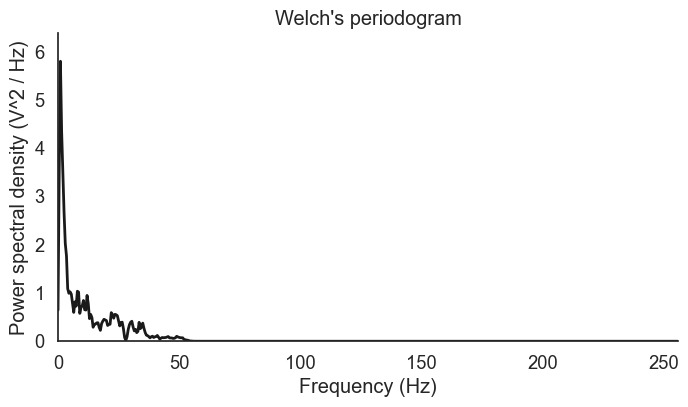

In [21]:
"""
Reference: https://raphaelvallat.com/bandpower.html
"""
# Define window length (4 seconds)
data = all_data['audio_hvha'].get_all_data()[MARKER.value]
sf = 512
win = 2 * sf
freqs, psd = signal.welch(data[0, :, 0], sf, nperseg=win)

# Plot the power spectrum
sns.set(font_scale=1.2, style="white")
plt.figure(figsize=(8, 4))
plt.plot(freqs, psd, color="k", lw=2)
plt.xlabel("Frequency (Hz)")
plt.ylabel("Power spectral density (V^2 / Hz)")
plt.ylim([0, psd.max() * 1.1])
plt.title("Welch's periodogram")
plt.xlim([0, freqs.max()])
sns.despine()

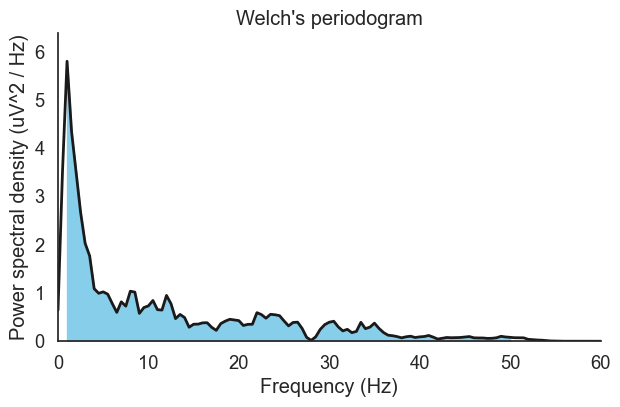

In [33]:
# Define lower and upper limits
low, high = 1, 50 #EEG_BANDS[Feature.GAMMA]

# Find intersecting values in frequency vector
idx_psd = np.logical_and(freqs >= low, freqs <= high)

# Plot the power spectral density and fill the delta area
plt.figure(figsize=(7, 4))
plt.plot(freqs, psd, lw=2, color="k")
plt.fill_between(freqs, psd, where=idx_psd, color="skyblue")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Power spectral density (uV^2 / Hz)")
plt.xlim([0, 60])
plt.ylim([0, psd.max() * 1.1])
plt.title("Welch's periodogram")
sns.despine()

In [34]:
psd[idx_psd].shape

(99,)

In [ ]:
# Frequency resolution
freq_res = freqs[1] - freqs[0]  # = 1 / 4 = 0.25

# Compute the absolute power by approximating the area under the curve
delta_power = simps(psd[idx_psd], dx=freq_res)
print(f"Absolute {BAND.name} power: %.3f uV^2" % delta_power)